# PyCBC Practice
Elizabeth Kapelevich

In [1]:
from pycbc.waveform import get_td_waveform      # imports a time domain waveform module
import pycbc.noise
from pycbc.detector import Detector
import matplotlib.pyplot as plt
import matplotlib
from pycbc.psd import aLIGOZeroDetHighPower
import numpy as np

In [2]:
time = 32                   # length of the signal
rate = 4096                 # sampling rate of the signal (one second of data has 4096 points)
f_low = 20                  # low-frequency threshold
tlen = rate * time          # length of the wave array is the product of total duration and sampling rate

In [3]:
sp, sc = get_td_waveform(approximant="SpinTaylorT4", mass1=5, mass2=5,
                        f_lower=f_low, delta_t=1.0/rate, inclination=0, phase_order=7,
                         amplitude_order=0, distance=75)

In [4]:
sp.resize(tlen)
sc.resize(tlen)

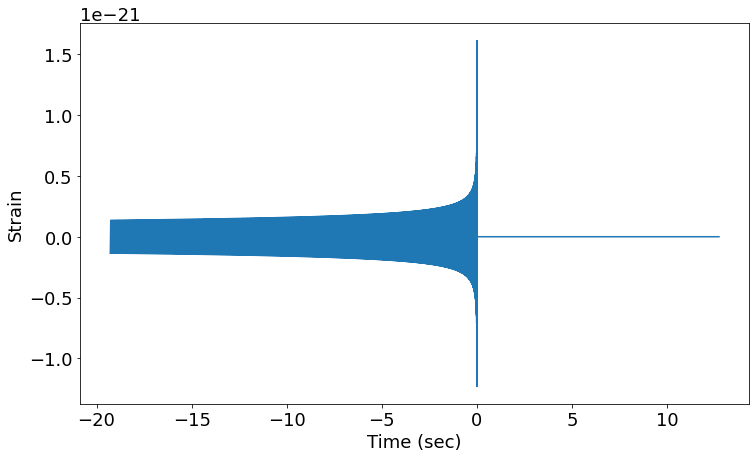

In [5]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 7))
plt.plot(sp.sample_times, sp)
plt.xlabel("Time (sec)")
plt.ylabel("Strain")
plt.show()

In [6]:
delta_f = 1/time
flen = int(tlen/2 + 1)

In [7]:
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)    # f_low is where it starts, length is flen, 
                                                     # and delta_f is frequency sampling rate

In [8]:
np.sqrt(psd.at_frequency(25))     # sensitivity of LIGO at given frequency

1.307361185615325e-23

In [9]:
frequency = np.linspace(20, 2000, 10000)
psd_vals = []
for f in frequency:
    psd_vals.append(psd.at_frequency(f))
psd_vals = np.array(psd_vals)

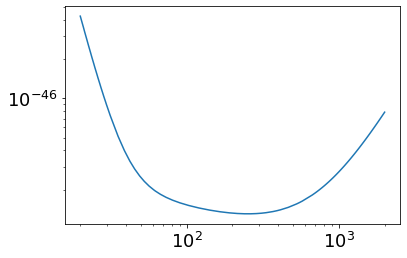

In [10]:
plt.loglog(frequency, psd_vals)  # makes both axes logs

In [11]:
# generating noise instance

delta_t = 1/rate
ts = pycbc.noise.noise_from_psd(tlen, delta_t, psd, seed = 100)          # pycbc noise module

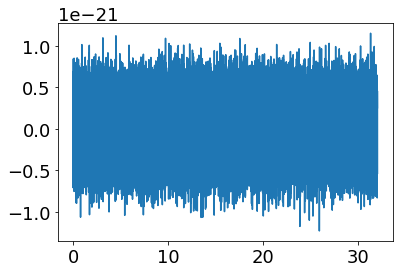

In [12]:
plt.plot(ts.sample_times, ts)

In [13]:
# converting noise spectrum into frequency series

fs = ts.to_frequencyseries()

In [14]:
keep = fs.sample_frequencies.data > 20

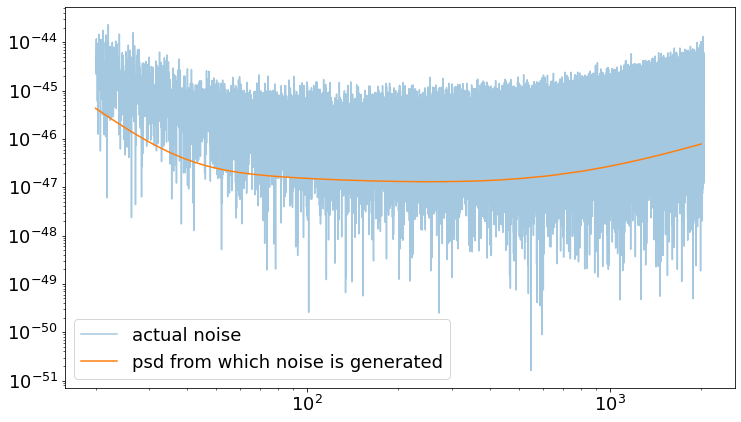

In [15]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,7))
plt.loglog((fs.sample_frequencies)[keep], np.abs(fs.data)[keep]**2, alpha=0.4, label="actual noise")
plt.loglog(frequency, psd_vals, label="psd from which noise is generated")
plt.legend()

In [16]:
# embedding signal within noise

ra = 1.2      # right ascension (radians)
dec = 1.7     # declination
psi = 0.1     # polarization angle
t = 1343586137

dh = Detector("H1")
dl = Detector("L1")
dv = Detector("V1")

In [17]:
fph, fch = dh.antenna_pattern(ra, dec, psi, t)
fpl, fcl = dl.antenna_pattern(ra, dec, psi, t)

In [18]:
ht = (fph * sp) + (fch * sc)  # created all orthogonal transofmrations
hl = (fpl * sp) + (fcl * sc)

In [19]:
ht.end_time.gpsSeconds, ht.end_time.gpsNanoSeconds

(12, 721679688)

In [20]:
hl.end_time.gpsSeconds, hl.end_time.gpsNanoSeconds

(12, 721679688)

In [21]:
sp.start_time

LIGOTimeGPS(-19, -278320312)

In [22]:
sp.start_time = sc.start_time = t

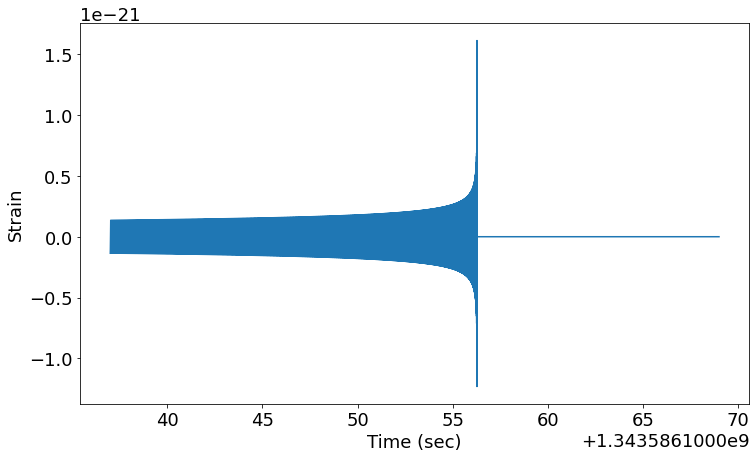

In [23]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 7))
plt.plot(sp.sample_times, sp)   # set it to the start time of the wave, no longer relative to 0!
plt.xlabel("Time (sec)")
plt.ylabel("Strain")
plt.show()

In [38]:
# directly creating h(t)

ht_hanford = dh.project_wave(sp, sc, ra, dec, psi)
ht_livingston = dl.project_wave(sp, sc, ra, dec, psi)

In [39]:
ht_hanford.start_time

LIGOTimeGPS(1343586136, 978271484)

In [26]:
ht_livingston.start_time

LIGOTimeGPS(1343586136, 982177734)

In [27]:
time_delay = ht_livingston.start_time - ht_hanford.start_time

In [28]:
time_delay.gpsNanoSeconds * 1e-6

3.90625

In [29]:
len(ht_hanford.data)

131139

In [30]:
len(ts)

131072

In [42]:
ht_hanford.resize(len(ts))

In [43]:
len(ht_hanford)

131072

In [44]:
ts.start_time = ht_hanford.start_time.gpsSeconds + ht_hanford.start_time.gpsNanoSeconds * 1e-9

In [45]:
data_hanford = ht_hanford + ts